# Handwritten digits classification

1. [Task description](#Task-description)   
2. [Dataset](#Dataset)   
3. [Neural Net architecture](#Architecture)   
4. [Training](#Training)   
5. [Model validation](#Model-validation)   
6. [Summary](#Model-validation)   
7. [What can be improved?](#Futher-research)

## Task description

Given the picture of handwritten digit we need to recognise what digit on the picture with the accuracy 98%.

## Dataset

We will be using _[MNIST](http://yann.lecun.com/exdb/mnist/)_ dataset for training as well as for model validation.   
MNIST dataset consists of handwritten digits, it has training set of 60 000  examples and testing set of 10 000 examples.   
Images size is 28x28 pixels in greyscale, besides images dataset contains labels of the images.

In [1]:
import numpy as np
import torch
from batchflow import Dataset, B, V 
from batchflow.models.torch import TorchModel
from batchflow.opensets import MNIST
from batchflow.batch_image import ImagesBatch
from batchflow.decorators import action
import matplotlib.pyplot as plt

We define custom MyBatch class and set components 'images' and 'labels'. Besides, we need @action method *type_cast* to cast input data types to be compatible with _[Pytorch](https://pytorch.org/)_.

In [2]:
class MyBatch(ImagesBatch):
    components = 'images', 'labels'
    @action
    def type_cast(self):
        self.images = np.array(self.images, dtype='float32')
        self.labels = np.array(self.labels, dtype='int64')
        return self

Loading dataset.

In [ ]:
dataset = MNIST(batch_class=MyBatch)

## Architecture

We will be using slightly modified architecture of _[LeNet-5.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)_

<img src="https://cdn-images-1.medium.com/max/1200/1*1TI1aGBZ4dybR6__DI9dzA.png"  />

Original LeNet-5 consists of:
1. conv layer: filters = 6, kernel_size = 5
2. pooling layer: type = 'avarage', pool_size = 2, strides = 2
3. conv layer2: filters = 16, kernel_size = 5
4. pooling layer: type = 'avarage', pool_size = 2, strides = 1
5. FC layer: units = 120
6. FC layer: units = 84
7. Gaussian connections: units = 10

Originally authors used normalisation technique that maps white pixels -> -0.1  and black pixels -> 1.175.
However, we instead use batch normalisation after conv-pool blocks. Besides, we use ReLU activation, instead of Sigmood. And finally in the last layer we replaced Radial Basis Function units with fully connected layer, that forces us to change loss function as well from mse to crossentropy.

In [25]:
from torch.nn import CrossEntropyLoss
config = { 
    'inputs': dict(images={'shape': (28, 28, 1)},
                  labels={'classes': 10,
                          'transform': 'ohe'}),
    'initial_block/inputs' : 'images',
    'loss': CrossEntropyLoss,
    'optimizer': 'Adam',
    'body/layout': 'cavn cavn fafa',
    'body/pool_size': [2, 2],
    'body/pool_strides': [2, 2],
    'body/filters': [6, 16],
    'body/units': [120, 84],
    'body/kernel_size': [5 , 5],
    'head/units': 10,
    'head/layout': 'f',
}

### Training

We trained our model using _[Adam](https://arxiv.org/abs/1412.6980)_ optimizer with default settings. Loss fucntion - CrossEntropyLoss, note that this loss inputs must be logits.      
We set batch_size to 64 and train the model for 20 epochs.

In [29]:
BATCH_SIZE = 64
train = (dataset.train.p
        .init_model('dynamic', TorchModel, 'my_model', config)
        .init_variable('loss', init_on_each_run=list)
        .to_array()
        .type_cast()
        .train_model('my_model', B('images'), B('labels'),
                      fetches='loss', save_to=V('loss'), mode='a')
        .run(BATCH_SIZE, shuffle=True, n_epochs=20))

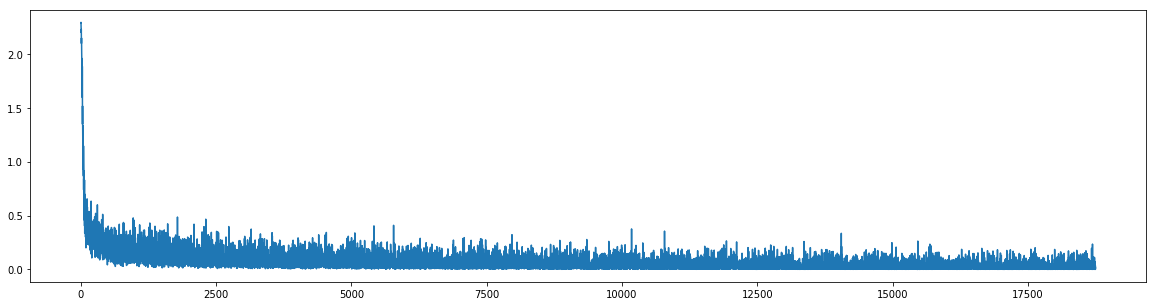

In [36]:
loss = train.get_variable('loss')
plt.figure(figsize=(20,5))
plt.plot(loss)

## Model validation

Now we run test pipiline to assess model's accuracy on test data.

In [30]:
test = (dataset.test.p
        .import_model('my_model', train)
        .init_variable('predictions', init_on_each_run=list)
        .init_variable('metrics', init_on_each_run=None)
        .to_array()
        .type_cast()
        .predict_model('my_model', B('images'), B('labels'), 
                       fetches=['predictions'], 
                       save_to=[ V('predictions')])
        .gather_metrics('class', targets=B('labels'), fmt='logits', axis=1,
                        predictions=V('predictions'), save_to=V('metrics'),
                        mode='a')

        .run(1, n_epochs=1))

In [40]:
metrics = test.get_variable('metrics')
acc = metrics.evaluate('accuracy')
print('Accuracy of the model on test data - {:.2%}'.format(acc))

Accuracy of the model on test data - 98.03%


## Summary

In oder to classify handwritten digits we trained LeNet5 like neural net. We achived 98% models accuracy.

## Futher research

Our models architecture is not very complicated. It was oroposed in 1998.
In oder to reach higher accuracy you can try:
 -  more add [conv pool] blocks to the model.
 - using more filters in conv blocks.